# Histograms

Install the histogram packages for root-to-julia interoperability if you don't have them yet.

~~~
julia> Pkg.clone("https://github.com/jpata/ROOTHistograms.jl")
julia> Pkg.clone("https://github.com/jpata/Histograms.jl")
~~~

In [75]:
using Histograms, ROOTHistograms, PyPlot, ROOT

Julia histograms have no special overflow or underflow bin. If you want to define an underflow, the lowest bin must be `[-Inf, firstbin)`. You can achieve this by creating a histogram explicitly with:

In [102]:
testhist = ErrorHistogram([-Inf, 0,1,2,3, Inf])

Histograms.ErrorHistogram{Float64,1,Tuple{Array{Float64,1}}}
edges:
  [-Inf,0.0,1.0,2.0,3.0,Inf]
weights: [0.0,0.0,0.0,0.0,0.0]
closed: left

Hence, anything between [-Inf,0.0) will fall to the first bin.

In [103]:
push!(testhist, -0.5)

Histograms.ErrorHistogram{Float64,1,Tuple{Array{Float64,1}}}
edges:
  [-Inf,0.0,1.0,2.0,3.0,Inf]
weights: [1.0,0.0,0.0,0.0,0.0]
closed: left

You can see that the weight in the first bin increased by 1.

In [104]:
contents(testhist)[1] == 1

true

The same holds for the overflow: anything between [3.0,+Inf) will end in the last bin.

In [105]:
push!(testhist, 4.0)

Histograms.ErrorHistogram{Float64,1,Tuple{Array{Float64,1}}}
edges:
  [-Inf,0.0,1.0,2.0,3.0,Inf]
weights: [1.0,0.0,0.0,0.0,1.0]
closed: left

We can do this automatically by defining a function which pads a vector with -Inf and +Inf. 

In [92]:
pad(v) = [-Inf, v..., Inf];

Note that `linspace(a,b,n)` creates a uniform grid between `a` and `b` in `n` points.

In [131]:
h1 = ErrorHistogram(pad(linspace(-1,1,11)))
h2 = ErrorHistogram(pad(linspace(-1,1,11)))

Histograms.ErrorHistogram{Float64,1,Tuple{Array{Float64,1}}}
edges:
  [-Inf,-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0,Inf]
weights: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
closed: left

We can fill the histograms with the `push!` method, which also accepts an optional weight.

In [132]:
for i=1:1000
    v = randn()
    push!(h1, v)
end

for i=1:100
    v = randn()
    w = 10.0
    push!(h2, v, w)
end

The `ROOTHistograms.jl` has a few simple methods for drawing histograms. 

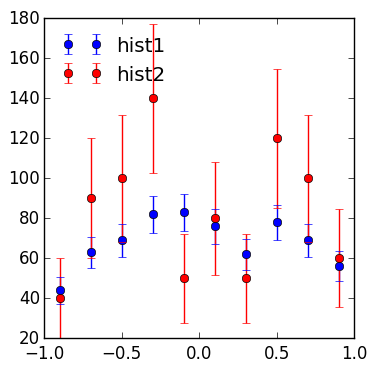

PyObject <matplotlib.legend.Legend object at 0x325c80250>

In [136]:
figure(figsize=(4,4))
errorbar(h1, linewidth=0, marker="o", elinewidth=1, color="blue", label="hist1");
errorbar(h2, linewidth=0, marker="o", elinewidth=1, color="red", label="hist2");
legend(loc="best", frameon=false)

Histograms with the same edges can be added.

In [140]:
h1+h2

Histograms.ErrorHistogram{Float64,1,Tuple{Array{Float64,1}}}
edges:
  [-Inf,-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0,Inf]
weights: [251.0,84.0,153.0,169.0,222.0,133.0,156.0,112.0,198.0,169.0,116.0,237.0]
closed: left

Stacked histograms can be plotted with using `bottom=v`, where v is the sum of the previous histogram contents.

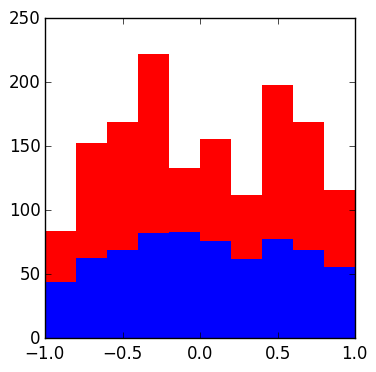

In [141]:
figure(figsize=(4,4))
bar(h1, color="blue", lw=0);
bar(h2, bottom=contents(h1), color="red", lw=0);

Histograms can be conveniently written to a ROOT file by specifying them in a Dict.

In [143]:
hists = Dict(
    "folder1/hist1"=>h1,
    "folder2/subfolder2/hist2"=>h2
)
write_hists_to_file(
    "hists.root",
    hists
)

In [144]:
tf = TFile("hists.root")

ROOT.TFile(Ptr{Void} @0x00007fba59be2480)

Load and convert the ROOT histogram to a julia histogram.

In [146]:
rh1 = root_cast(TH1D, Get(tf, "folder1/hist1"))

ROOT.TH1D(Ptr{Void} @0x00007fba59b24900)

We can verify that the data are preserved after loading.

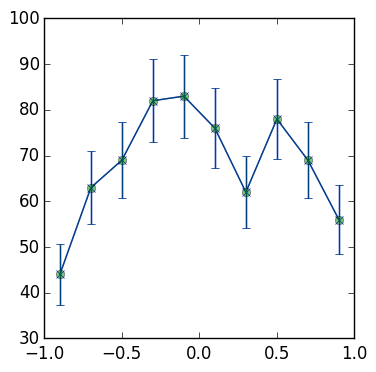

In [147]:
figure(figsize=(4,4))
errorbar(from_root(rh1), marker="x")
errorbar(h1, marker="o", alpha=0.5);